# Data Exploration

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings

## Training data

In [8]:
train = pd.read_csv('~/Desktop/kaggle/input/RSNA/train.csv')
print("Total Cases: ", len(train))

Total Cases:  1975


In [11]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


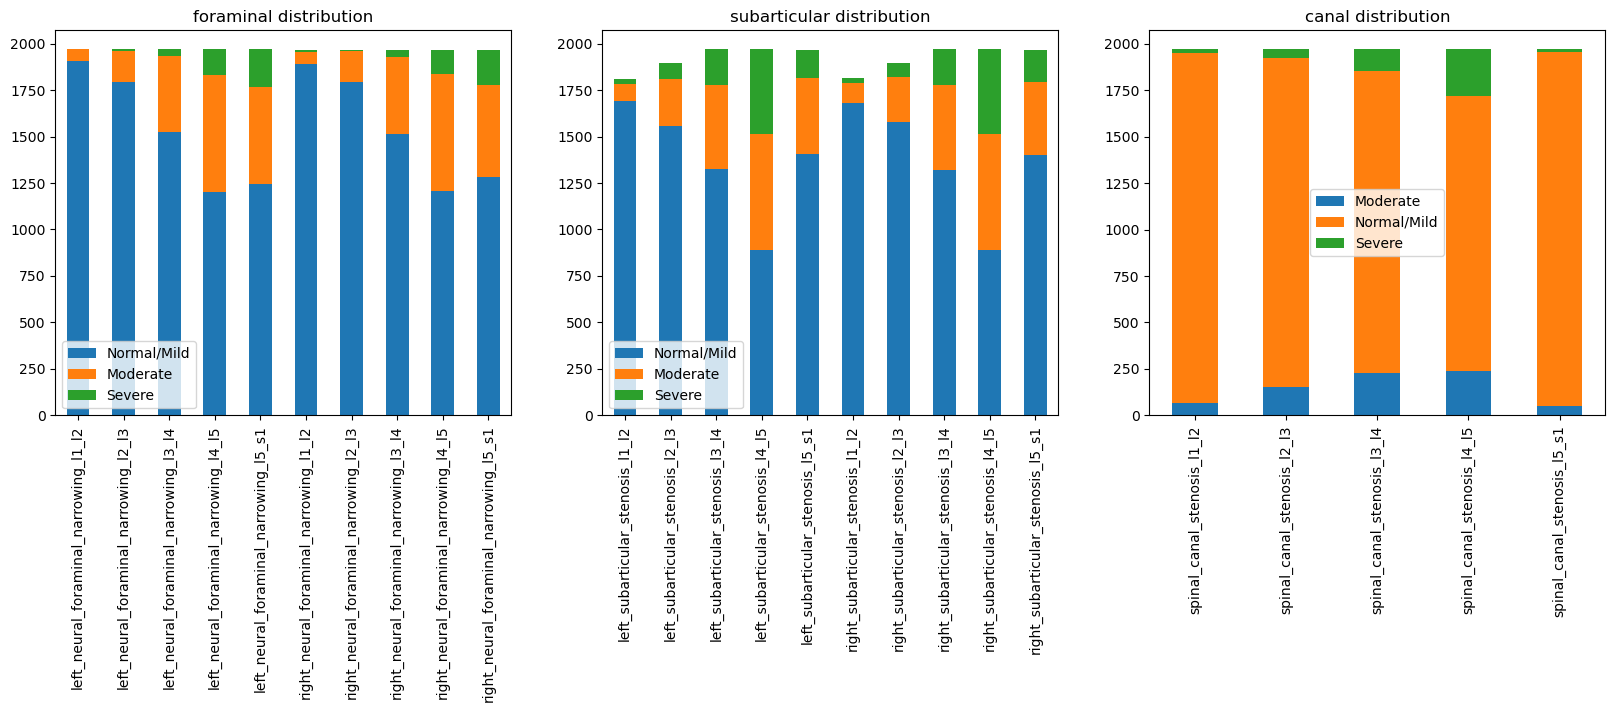

In [12]:
# Create a fig and a 1x3 grid of subplots w/ a tot size of 20 x 5 inches
figure, axis = plt.subplots(1, 3, figsize=(20, 5))

# Loop through list of diagnoses ['foraminal', 'subarticular', 'canal'] and their index (idx)
for idx, d in enumerate(['foraminal', 'subarticular', 'canal']):
    
    # Filter the cols in the df that contain the current diagnostic term 'd'
    diagnosis = list(filter(lambda x: x.find(d) > -1, train.columns))
    
    # Select the filtered cols from the df
    dff = train[diagnosis]
    
    # Catch and ignore future warnings reduce output clutter
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        # Calculate the value counts for each col in dff, fill missing values with 0, and transpose the result
        value_counts = dff.apply(pd.value_counts).fillna(0).T
    
    # Plot the value counts
    value_counts.plot(kind='bar', stacked=True, ax=axis[idx])
    
    # Set the title of the current subplot based on the diagnostic term
    axis[idx].set_title(f'{d} distribution')


## Loading images

In [19]:
directory = os.path.expanduser('~/Desktop/kaggle/input/RSNA/train_images')
part_1 = os.listdir(directory)
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))

In [22]:
df_meta_f = pd.read_csv('~/Desktop/kaggle/input/RSNA/train_series_descriptions.csv')
df_meta_f.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [29]:
# Create a list of tuples where each tuple contains a filename and its full path
p1 = [(x, os.path.join(directory, x)) for x in part_1]

# Create a dictionary where:
# - Each key is a filename
# - Each value is another dictionary containing:
#   - 'folder_path': the full path to the directory
#   - 'SeriesInstanceUIDs': an empty list (to be filled later)
meta_obj = { p[0]: { 'folder_path': p[1], 
                    'SeriesInstanceUIDs': [] 
                   } 
            for p in p1 }

# Iterate over each key in the meta_obj dict
for m in meta_obj:
    # For each folder_path in meta_obj, list the contents and filter out any filenames containing '.DS'
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1, 
               os.listdir(meta_obj[m]['folder_path'])
              )
    )

# Iterate over each key in the meta_obj dict
for k in tqdm(meta_obj):
    # For each SeriesInstanceUID in the current entry
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        # If 'SeriesDescriptions' key is not in the current entry, initialize it as an empty list
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            # Try to append the series description from the DataFrame to 'SeriesDescriptions'
            meta_obj[k]['SeriesDescriptions'].append(
                df_meta_f[(df_meta_f['study_id'] == int(k)) & 
                (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

100%|██████████| 1975/1975 [00:01<00:00, 1685.93it/s]


In [32]:
# Make sure it worked... 
meta_obj[list(meta_obj.keys())[1]]

{'folder_path': '/Users/smarrakchi/Desktop/kaggle/input/RSNA/train_images/213335325',
 'SeriesInstanceUIDs': ['1062372272', '858832151', '1153454550'],
 'SeriesDescriptions': ['Sagittal T1', 'Sagittal T2/STIR', 'Axial T2']}

### Take a look at images for a given patient

In [33]:
patient = train.iloc[1]
ptobj = meta_obj[str(patient['study_id'])]
print(ptobj)

{'folder_path': '/Users/smarrakchi/Desktop/kaggle/input/RSNA/train_images/4646740', 'SeriesInstanceUIDs': ['3486248476', '3666319702', '3201256954'], 'SeriesDescriptions': ['Sagittal T1', 'Sagittal T2/STIR', 'Axial T2']}


In [35]:
# Get data into the format:
"""
im_list_dcm = {
    '{SeriesInstanceUID}': {
        'images': [
            {'SOPInstanceUID': ...,
             'dicom': PyDicom object
            },
            ...,
        ],
        'description': # SeriesDescription
    },
    ...
}
"""

# Initialize an empty dictionary to store DICOM image information
im_list_dcm = {}

# Iterate over the indices and SeriesInstanceUIDs in ptobj['SeriesInstanceUIDs']
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    
    # Create an entry in the dictionary for each SeriesInstanceUID
    # Initialize with an empty list for 'images' and the corresponding description
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    
    # Use glob to find all DICOM files (.dcm) in the corresponding folder path
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm")
    
    # Sort the list of image files based on the numeric part of the filename
    # Extract the numeric part by removing '.dcm' and converting to int
    for j in sorted(images, key=lambda x: int(x.split('/')[-1].replace('.dcm', ''))):
        
        # Append a dictionary containing the SOPInstanceUID and the DICOM file read using pydicom
        im_list_dcm[i]['images'].append({
            'SOPInstanceUID': j.split('/')[-1].replace('.dcm', ''),  # Extract SOPInstanceUID from filename
            'dicom': pydicom.dcmread(j)  # Read the DICOM file and store it
        })

In [41]:
im_list_dcm

{'3486248476': {'images': [{'SOPInstanceUID': '1',
    'dicom': Dataset.file_meta -------------------------------
    (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
    (0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
    (0002, 0003) Media Storage SOP Instance UID      UI: 4646740.1.1
    (0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
    (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
    (0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
    -------------------------------------------------
    (0008, 0018) SOP Instance UID                    UI: 4646740.1.1
    (0008, 0023) Content Date                        DA: '20240503'
    (0008, 0033) Content Time                        TM: '223734.008099'
    (0008, 103e) Series Description                  LO: ''
    (0010, 0020) Patient ID                          LO: '4646740'
    (0018, 0050) Slice Thickness                     DS:

In [36]:
# Function to display images
def display_images(images, title, max_images_per_row=4):
    # Calculate the number of rows needed
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Ceiling division

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5, 1.5 * num_rows))
    
    # Flatten axes array for easier looping if there are multiple rows
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable for consistency

    # Plot each image
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image, cmap='gray')  # Assuming grayscale for simplicity, change cmap as needed
        ax.axis('off')  # Hide axes

    # Turn off unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()

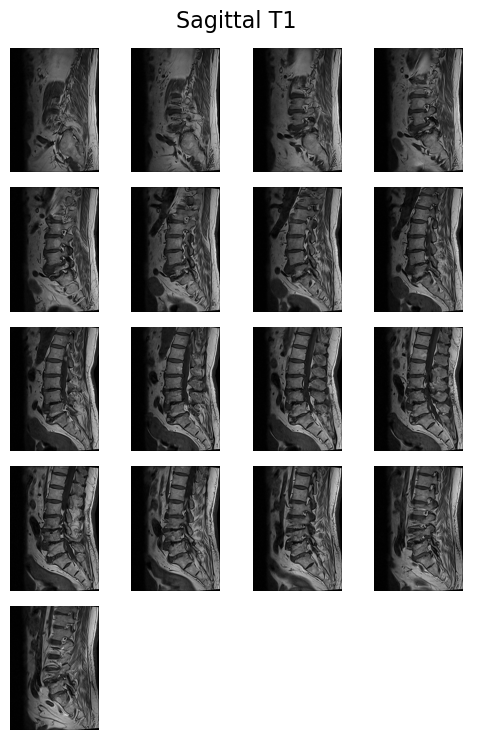

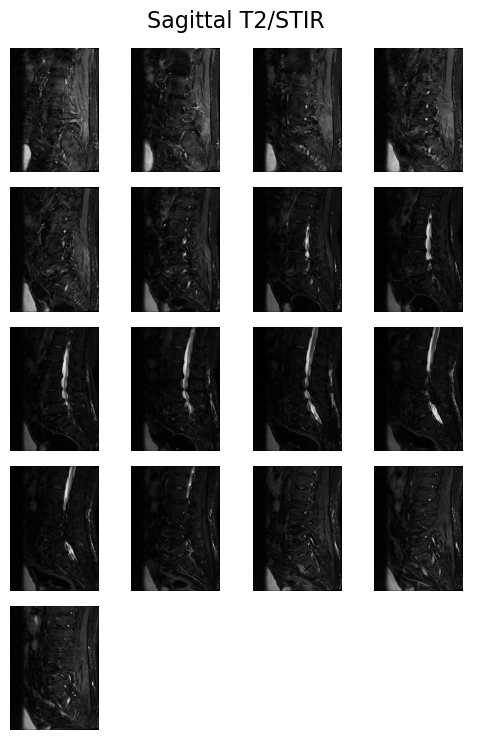

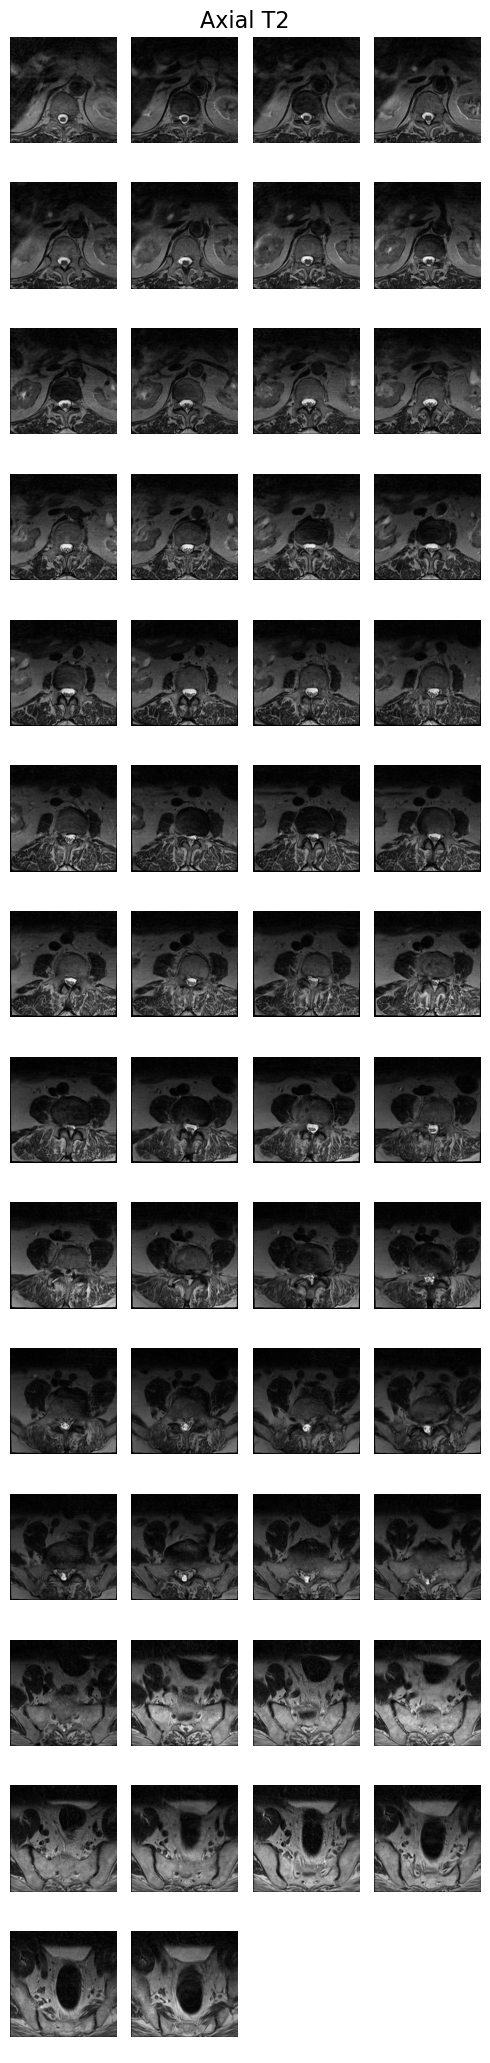

In [37]:
for i in im_list_dcm:
    display_images([x['dicom'].pixel_array for x in im_list_dcm[i]['images']], 
                   im_list_dcm[i]['description'])

## Coordinates

In [39]:
df_coor = pd.read_csv('~/Desktop/kaggle/input/RSNA/train_label_coordinates.csv')
df_coor.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [59]:
def display_coor_on_img(c, i, title):
    center_coordinates = (int(c['x']), int(c['y']))
    radius = 12
    color = (255, 0, 0)  # Red color in BGR
    thickness = 2
    IMG = i['dicom'].pixel_array
    IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    IMG_with_circle = cv2.circle(IMG_normalized.copy(), center_coordinates, radius, color, thickness)
    
    # Convert the image from BGR to RGB for correct color display in matplotlib
    IMG_with_circle = cv2.cvtColor(IMG_with_circle, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(IMG_with_circle)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(title)
    plt.show()

In [48]:
coor_entries = df_coor[df_coor['study_id'] == int(patient['study_id'])]

Only showing severe cases for this patient


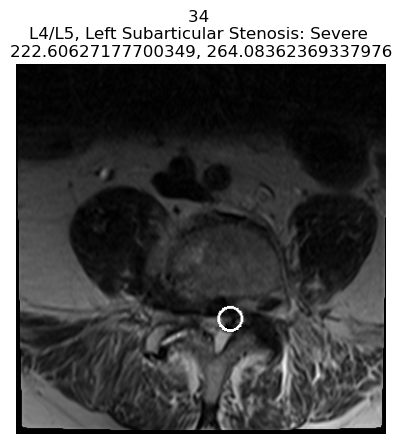

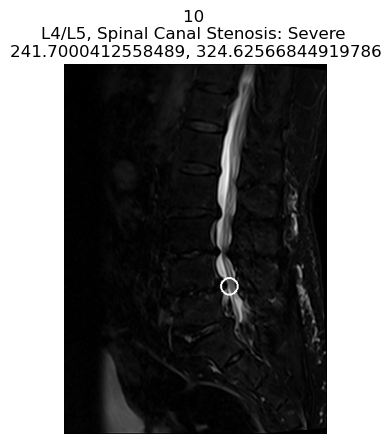

In [60]:
print("Only showing severe cases for this patient")

# Iterate over each row in the DataFrame 'coor_entries'
for idc, c in coor_entries.iterrows():
    
    # Iterate over each image in the dictionary corresponding to the current series_id
    for i in im_list_dcm[str(c['series_id'])]['images']:
        
        # Check if the SOPInstanceUID of the image matches the instance_number in 'c'
        if int(i['SOPInstanceUID']) == int(c['instance_number']):
            try:
                # Try to retrieve the patient severity from a dynamically constructed key
                patient_severity = patient[
                    f"{c['condition'].lower().replace(' ', '_')}_{c['level'].lower().replace('/', '_')}"
                ]
            except Exception as e:
                # If there's an error (e.g., key not found), set patient_severity to "unknown severity"
                patient_severity = "unknown severity"
            
            # Construct the title for display using SOPInstanceUID, condition, level, severity, and coordinates
            title = f"{i['SOPInstanceUID']} \n{c['level']}, {c['condition']}: {patient_severity} \n{c['x']}, {c['y']}"
            
            # If the patient severity is 'Severe', call the function to display the coordinates on the image
            if patient_severity == 'Severe':
                display_coor_on_img(c, i, title)